In [1]:
# Author: Saurav
# This file contains the PnP reconstruction and Baseline U-Net reconstruction results
# Specifications:

# Brain Data: /storage/fastMRI_brain/data/
# GRO Sampling Pattern
# acceleration R = 4
# No noise added

# Training Data: (refer notability notes) It uses 1541 (3T AXT2 volumes with coils >= 8) x 8 (bottom large brain slices) = 12328 image data from /storage/fastMRI_brain/data/multicoil_train
# Validation Data: (refer notability notes) It uses 421 (3T AXT2 volumes with coils >= 8) x 8 (bottom large brain slices) = 3368 image data from /storage/fastMRI_brain/data/multicoil_val
# Testing Data is same as Validation Data (might have considered subset of Validation for testing)
# the above numbers might be a rough estimate since a few images are left out because of size restiction and number of coil . I think the numbers are 12256 and 3352

# The multicoil data (coils>=8) was reduced to 8 coil data using the compression procedure from Prof. Ahmad's group. Prof. Ahmad mentioned that this is a standard procedure and we donot loose any significant information during this step. 

# Both PnP and U-Net code reconstructs 384x384 image, but for computing performance we look at center 320x320 image.


######## IMPORTANT #########

# The code requires you to modify the spectral_nrom.py file

######## IMPORTANT #########


import pathlib
import random
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import sigpy.plot as pl
import h5py
import torch
from espirit import espirit, espirit_proj, ifft, fft
import time
# from pMRI_Op_2D_t import pMRI_Op_2D_t
from denoiser_GPU import CNN_denoiser
from skimage.restoration import denoise_wavelet
import os
from skimage.measure import compare_ssim
from scipy.sparse.linalg import LinearOperator, cg
from common.evaluate import nmse, psnr

from models.PnP.dncnn import DnCNN

from matplotlib import pyplot as plt
%matplotlib inline

import sigpy as sp
import sigpy.mri as mr

import torch

from data import transforms
from common.subsample import MaskFunc
from Walsh_coil_estimation import calculate_csm_walsh


from collections import defaultdict


from torch.utils.data import DataLoader


from espirit import espirit, espirit_proj, ifft, fft

# import bart
import sigpy as sp
import sigpy.mri as mr


from common import utils

# from common.args import Args
from common.args_new_brain import Args # changes resolution to 384 here and included separate data paths args request for training and validation
from common.subsample import MaskFunc
from common.utils import tensor_to_complex_np

from skimage.measure import compare_ssim

from data import transforms

from data.brain_mri_data_UNet import SelectiveSliceData_Train
from data.brain_mri_data_UNet import SelectiveSliceData_Val

from data.multicoil_sim import get_coil_images, mask_coil_images

from models.PnP.dncnn import DnCNN
from models.PnP.train_denoiser_multicoil_brain import load_model

from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import lsqr

# from models.unet.run_unet_multi import optimal_scale

import scipy.misc
import PIL
import copy

import pathlib
from pathlib import Path 
import xml.etree.ElementTree as ET

import h5py

# from models.unet.unet_model import UnetModel
from models.unet.unet_model import UnetModel
# from data.multicoil_sim import get_coil_images, mask_coil_images

# from models.unet.unet_model_with_skip_connection import UnetModel
from scipy.io import savemat

In [4]:
class Init_Arg:
    def __init__(self):
        self.seed=42
        self.resolution=384
        self.challenge='multicoil' # Not used
        self.data_path_val ='/storage/fastMRI_brain/data/multicoil_val'
        self.sample_rate=1.  
        self.accelerations=[4]
        self.center_fractions=[0.08]
        self.output_path = None
        self.snr = 20 # Not used
        self.project = False # Not used
        self.algorithm = 'pnp-pds'
        self.num_iters = 100
        self.inner_iters = 3 # Not used
        self.inner_denoiser_iters = 1 # Not used
        self.step_size = 0.1 # Not used
        self.lamda = 0.01 # Not used
        self.relaxation = 0.000 # Not used
        self.beta = 0.0005 #0.0005 works well, 0.001 gives okish results. 0.001 works good for admm # Not used
        self.beta_desc = 0.04 # Not used
        self.device=0 
        self.denoiser_mode='2-chan'
        
        self.checkpoint_denoiser= '/storage/fastMRI_brain/PnP_brain/models/DnCNN/Trial_7/model.pt'

        self.debug=True # not used
        self.test_idx=0  # not used
        self.natural_image=False # not used
        self.normalize='constant' 
        self.rotation_angles=0 
        self.accel=False 
        self.use_mid_slices=True  # not used
        self.scanner_strength=3  # not used
        self.scanner_mode = 'PD' # not used
        self.run_name=None # not used
        
        self.resnorm=1 # not used
        self.resnorm_2=1 # not used
        self.noise_var = 1 # not used
        self.nc=4 

        self.coil_root = 'coil_maps/' # not used
        self.rss_target = True
#         self.rss_target = False
        self.optimal_scaling = False # not used
#         self.espirit_cal = False
        self.espirit_cal = True # not used
        self.map_num = 5 # not used
#         self.map_num = 6
        self.gamma_1 = 1; # not used
        self.tresh_mul = 70; # not used
        self.damp = 0.5; # not used
        self.method_2 = True # not used
        self.initialise_zero = False # not used

        self.set_gamma_1_2_equal = False # not used
        self.use_1_norm_for_res = True # not used
        self.mul_update_with_cap = True # not used
        self.mul_update_cap_high = 2 # not used
        self.mul_update_cap_low = 0.5 # not used
        self.use_pre_determined_noise_var = True # not used
        self.set_noise_variance = 5.3459594390181664e-11 # not used
        self.control_gamma_2 = 1 # not used
        self.use_only_x_and_z_residual = False # not used
        self.PDS_theta = 1 # not used
        self.GAMMA = 1 # not used
        self.tresh_mul_2 = 10 # not used
        self.damp_2 = 0.4 # not used
        self.normalised_Ah_initialization = True # not used
        self.use_damped_PDS_theta = False # not used
        self.num_of_top_slices = 8 

#         self.checkpoint_UNet = '/storage/fastMRI_brain/PnP_brain/models/Unet/Baseline_Unet/Trial_1/best_model.pt'
        self.checkpoint_UNet = '/storage/fastMRI_brain/PnP_brain/models/Unet/Baseline_Unet/Trial_1/model.pt'
       
        self.num_chans_UNet = 256
        self.num_pools_UNet = 4
        self.drop_prob_UNet = 0.0
        self.in_chans_UNet = 1
        self.op_chans_UNet = 1

In [5]:
def flatten(t):
    t = t.reshape(1,-1)
    t = t.squeeze()
    return t

def unflatten(t,shape_t):
    t = t.reshape(shape_t)
    return t

def nmse_tensor(gt, pred):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return torch.norm(gt - pred) ** 2 / torch.norm(gt) ** 2

In [6]:
class DataTransform:
    """
    Data Transformer for training U-Net models.
    """

    def __init__(self, args, use_seed=False):
        """
        Args:
            mask_func (common.subsample.MaskFunc): A function that can create  a mask of
                appropriate shape.
            resolution (int): Resolution of the image.
            which_challenge (str): Either "singlecoil" or "multicoil" denoting the dataset.
            use_seed (bool): If true, this class computes a pseudo random number generator seed
                from the filename. This ensures that the same mask is used for all the slices of
                a given volume every time.
        """
        self.use_seed = use_seed
        self.args = args
        self.mask = None
#         if args.mask_path is not None:
#             self.mask = torch.load(args.mask_path)

    def __call__(self, kspace, target, attrs, fname, slice):
        """
        Args:
            kspace (numpy.array): Input k-space of shape (num_coils, rows, cols, 2) for multi-coil
                data or (rows, cols, 2) for single coil data.
            target (numpy.array): Target image
            attrs (dict): Acquisition related information stored in the HDF5 object.
            fname (str): File name
            slice (int): Serial number of the slice.
        Returns:
            (tuple): tuple containing:
                image (torch.Tensor): Zero-filled input image.
                target (torch.Tensor): Target image converted to a torch Tensor.
                mean (float): Mean value used for normalization.
                std (float): Standard deviation value used for normalization.
                norm (float): L2 norm of the entire volume.
        """
        # GRO Sampling mask:
        a = np.array([0,10,19,28,37,46,54,61,69,76,83,89,95,101,107,112,118,122,127,132,136,140,144,148,151,155,158,161,164,
                 167,170,173,176,178,181,183,186,188,191,193,196,198,201,203,206,208,211,214,217,220,223,226,229,233,236,
                 240,244,248,252,257,262,266,272,277,283,289,295,301,308,315,323,330,338,347,356,365,374])
        m = np.zeros((384,384))
        m[:,a] = True
        m[:,176:208] = True
        
#         a = np.array([1,9,16,24,31,38,45,51,57,64,70,75,81,86,92,97,102,107,111,116,120,125,129,133,137,141,145,148,152,155,159,162,166,169,172,176,179,
#                       180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,207,210,214,217,220,224,227,231,
#                       234,238,241,245,249,253,257,261,266,270,275,279,284,289,294,300,305,311,316,322,329,335,341,348,355,362,370,377])
        
#         m = np.zeros((384,384))
#         m[:,a] = True

        
        samp = m
        numcoil = 8
        mask = np.tile(samp,(numcoil,1,1)).transpose((1,2,0)).astype(np.float32)
        nnz_index_mask = mask[0,:,0].nonzero()[0]

#         non_mask = np.ones([16,384,384])
#         non_mask[:,:,nnz_index_mask] = 0 
#         non_mask = transforms.to_tensor(non_mask)
        
#         print('kspace dimentions')
        kspace = kspace.transpose(1,2,0) 

        x = ifft(kspace, (0,1)) #(768, 396, 16)

        coil_compressed_x = ImageCropandKspaceCompression(x) #(384, 384, 8)

        RSS_x = np.squeeze(Rss(coil_compressed_x))# (384, 384)

        kspace = fft(coil_compressed_x, (1,0)) #(384, 384, 8)
        
        masked_kspace = kspace*mask
        
#         print(kspace.shape)
        kspace = transforms.to_tensor(kspace)
#         print(kspace.shape)
        kspace = kspace.permute(2,0,1,3)
    
    
        masked_kspace = transforms.to_tensor(masked_kspace)
#         print(kspace.shape)
        masked_kspace = masked_kspace.permute(2,0,1,3)


    
    
    
##################
        nnz_index_mask = mask[0,:,0].nonzero()[0]

        sig_power = torch.sum(masked_kspace**2)
        snr_ratio = 10**(args.snr/10)
#             noise_var = sig_power/snr_ratio/(kspace.shape[0]*len(nnz_index_mask)*2)
#         if args.use_pre_determined_noise_var == True:
#             noise_var = torch.tensor(args.set_noise_variance)
#         else:
        noise_var = sig_power/snr_ratio/(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask))
    
#         noise_var = torch.tensor(1.1421833617797361e-10)
        
        print('noise variance of this run:')
        print(format(noise_var))

#             noise_var_dummy = sig_power/snr_ratio/(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask))
#             print(noise_var_dummy)
#             print(noise_var)
#             print(noise_var.shape)
# #             print('hi')
#             print(masked_kspace.shape[0])
#             print(masked_kspace.shape[1])
#             print('hi')
#             print(masked_kspace.shape)

        nnz_masked_kspace = masked_kspace[:,:,nnz_index_mask,:]
#             print(nnz_masked_kspace.shape)
        nnz_masked_kspace_real = nnz_masked_kspace[:,:,:,0]
        nnz_masked_kspace_imag = nnz_masked_kspace[:,:,:,1]
        nnz_masked_kspace_real_flat = flatten(nnz_masked_kspace_real)
        nnz_masked_kspace_imag_flat = flatten(nnz_masked_kspace_imag)

        noise_flat_1 = (torch.sqrt(0.5*noise_var))*torch.randn(nnz_masked_kspace_real_flat.size())
        noise_flat_2 = (torch.sqrt(0.5*noise_var))*torch.randn(nnz_masked_kspace_real_flat.size())

        nnz_masked_kspace_real_flat_noisy = nnz_masked_kspace_real_flat + noise_flat_1
        nnz_masked_kspace_imag_flat_noisy = nnz_masked_kspace_imag_flat + noise_flat_2

        nnz_masked_kspace_real_noisy = unflatten(nnz_masked_kspace_real_flat_noisy,nnz_masked_kspace_real.shape)
        nnz_masked_kspace_imag_noisy = unflatten(nnz_masked_kspace_imag_flat_noisy,nnz_masked_kspace_imag.shape)

        nnz_masked_kspace_noisy = nnz_masked_kspace*0
        nnz_masked_kspace_noisy[:,:,:,0] = nnz_masked_kspace_real_noisy
        nnz_masked_kspace_noisy[:,:,:,1] = nnz_masked_kspace_imag_noisy

        masked_kspace_noisy = 0*masked_kspace
        masked_kspace_noisy[:,:,nnz_index_mask,:] = nnz_masked_kspace_noisy

        #testing
        pow_1 = torch.sum(nnz_masked_kspace_real_flat**2)
        pow_2 = torch.sum(nnz_masked_kspace_imag_flat**2)
        pow_3 = torch.sum(noise_flat_1**2)
        pow_4 = torch.sum(noise_flat_2**2)
        ratio_snr = torch.sqrt(pow_1 + pow_2)/torch.sqrt(pow_3 + pow_4)
        SNRdB_test = 20*torch.log10(ratio_snr)
        print('SNR in dB for this run:')
        print(SNRdB_test)
#################
        masked_kspace = masked_kspace_noisy
#         print('NO NOISE ADDED!')
        

#             args.resnorm = torch.sqrt(noise_var*(kspace.shape[0]*len(nnz_index_mask)*2))
#             args.resnorm = torch.sqrt(noise_var*(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask)))

#             args.resnorm = 0.88*torch.sqrt(noise_var*(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask)))
#             args.resnorm = 0.98*torch.sqrt(noise_var*(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask)))
        args.resnorm = torch.sqrt(noise_var*(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask)))
        args.resnorm_2 = torch.sqrt(noise_var*(masked_kspace.shape[0]*masked_kspace.shape[1]*len(nnz_index_mask)))
        args.noise_var = noise_var
#         print(args.resnorm)


        
        ##################################

        
        
        
        
        
    
    
    
    
#         path_name = '/storage/fastMRI_brain/Sens_Maps/8coil_val'

#         fname_full = 'slice_' + str(slice) + '_' + fname
        
#         sens_map_file_name = Path(path_name,fname_full)
#         with h5py.File(sens_map_file_name, 'r') as data:
#             sens_map_foo = np.array(list(data['sens_map']))
            
#         lsq_gt = np.sum(sens_map_foo.conj()*coil_compressed_x , axis = -1)

       
    
    
    
        
        
        kspace_np = tensor_to_complex_np(masked_kspace)
        ESPIRiT_tresh = 0.02 # old 0.02
        ESPIRiT_crop = 0.96 # old 0.96; 
        ESPIRiT_width_full = 24
        ESPIRiT_width_mask = 24
        device=sp.Device(0)

        sens_maps = mr.app.EspiritCalib(kspace_np,calib_width= ESPIRiT_width_mask,thresh=ESPIRiT_tresh, kernel_width=6, crop=ESPIRiT_crop,device=device,show_pbar=False).run()

        sens_maps = sp.to_device(sens_maps, -1)
        sens_map_foo = np.zeros((args.resolution,args.resolution,8)).astype(np.complex)
        for  i in range(8):
            sens_map_foo[:,:,i] = sens_maps[i,:,:]
        sens_maps = transforms.to_tensor(sens_maps.astype('complex64'))
        lsq_gt = np.sum(sens_map_foo.conj()*coil_compressed_x , axis = -1)
        
        
        
        
        
        # Apply mask
        seed = None if not self.use_seed else tuple(map(ord, fname))

        nnz_index_mask = mask[0,:,0].nonzero()[0]
     
        y_ifft_under_sampled = transforms.ifft2(masked_kspace)
        y_ifft_fully_sampled = transforms.ifft2(kspace)
        
        y_ifft_fully_sampled_abs = transforms.complex_abs(y_ifft_fully_sampled)
        target = transforms.root_sum_of_squares(y_ifft_fully_sampled_abs)
        
        
        y_ifft_under_sampled_abs = transforms.complex_abs(y_ifft_under_sampled)
        image = transforms.root_sum_of_squares(y_ifft_under_sampled_abs)
        
        # Normalize input
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        image_UNet = image.clamp(-6, 6)

        # Normalize target
        target = transforms.normalize(target, mean, std, eps=1e-11)
        target_UNet = target.clamp(-6, 6)
        
        return image_UNet, target_UNet, mean, std, masked_kspace, mask, kspace, RSS_x, coil_compressed_x ,fname, slice, sens_map_foo, lsq_gt #, attrs['norm'].astype(np.float32)

In [7]:
def create_data_loader(args):

    train_data = SelectiveSliceData_Val(
        root=args.data_path_val,
        transform=DataTransform(args),
        challenge='multicoil',
        sample_rate=1,
        use_top_slices=True,
        number_of_top_slices=args.num_of_top_slices,
        fat_supress=None,
        strength_3T=None,
        restrict_size=False,
    )

        
    return train_data

In [8]:
def Rss(x):
    y = np.expand_dims(np.sum(np.abs(x)**2,axis = -1)**0.5,axis = 2)
    return y

def ImageCropandKspaceCompression(x):
#     print(x.shape)
#     plt.imshow(np.abs(x[:,:,0]), origin='lower', cmap='gray')
#     plt.show()
        
    w_from = (x.shape[0] - 384) // 2  # crop images into 384x384
    h_from = (x.shape[1] - 384) // 2
    w_to = w_from + 384
    h_to = h_from + 384
    cropped_x = x[w_from:w_to, h_from:h_to,:]
    if cropped_x.shape[-1] >= 8:
        x_tocompression = cropped_x.reshape(384**2,cropped_x.shape[-1])
        U,S,Vh = np.linalg.svd(x_tocompression,full_matrices=False)
        coil_compressed_x = np.matmul(x_tocompression, Vh.conj().T)
        coil_compressed_x = coil_compressed_x[:,0:8].reshape(384,384,8)
    else:
        coil_compressed_x = cropped_x
        
    return coil_compressed_x

In [9]:
def denoiser(noisy,model,args):
    # add rotate
    noisy, rot_angle = transforms.best_rotate(noisy, args.rotation_angles)

    # normalize
    if (args.normalize == 'max') or (args.normalize == 'std'):
        noisy, scale = transforms.denoiser_normalize(noisy, is_complex=True, use_std=args.normalize=='std')
    elif args.normalize=='constant':
#         print('hi')
        scale = 0.0016
#         if args.espirit_cal:
#             scale = scale/15
        noisy = noisy*(1/scale)
    else:
        scale = 1

    if args.denoiser_mode=='mag':
        mag = transforms.complex_abs(noisy)
        phase = transforms.phase(noisy)
        denoised_mag = model(mag[None, None,...])
        denoised_mag = denoised_mag[0,0,...]
        denoised_image = transforms.polar_to_rect(denoised_mag, phase)

    elif args.denoiser_mode == '2-chan':
        # move real/imag to channel position
        noisy = noisy.permute(2,0,1).unsqueeze(0)
        denoised_image = model(noisy).squeeze(0).permute(1,2,0)

    elif args.denoiser_mode == 'real-imag':
        # move real/imag to batch position
        noisy = noisy.permute(2,0,1).unsqueeze(1)
        denoised_image = model(noisy).squeeze(1).permute(1,2,0)

    # unnormalize
    
    denoised_image = denoised_image*scale

    # undo rotate
    denoised_image = transforms.polar_to_rect(transforms.complex_abs(denoised_image), transforms.phase(denoised_image)-rot_angle)

    return denoised_image

In [10]:
class A_mri:
    def __init__(self,sens_maps,mask):
        self.sens_maps = sens_maps
        self.mask = mask
    
    def A(self,x):
        x = x[None, ...]
        y = transforms.complex_mult(x,self.sens_maps)    
        y_fft = transforms.fft2(y)
        out = self.mask * y_fft
        return out

    def H(self,x):
        y = self.mask*x
        y_ifft = transforms.ifft2(y)
        out = torch.sum(transforms.complex_mult(y_ifft,transforms.complex_conj(self.sens_maps)), dim=0)
        return out

In [11]:
class B_mri:
    def __init__(self,sens_maps,mask):
        self.sens_maps = sens_maps
        self.mask = mask
    
    def A(self,x):
        x = x[None, ...]
        y = transforms.complex_mult(x,self.sens_maps)    
        y_fft = transforms.fft2(y)
        out = self.mask * y_fft
        return out

    def H(self,x):
        y = self.mask*x
        y_ifft = transforms.ifft2(y)
        out = torch.sum(transforms.complex_mult(y_ifft,transforms.complex_conj(self.sens_maps)), dim=0)
        return out

In [12]:
class C_mri:
    def __init__(self,mat_E,mri_B):
        self.mat_E = mat_E
        self.mri_B = mri_B
    
    def A(self,x):
        out =  self.mri_B.H(self.mat_E*self.mri_B.A(x))
        return out

    def H(self,x):
        out =  self.mri_B.H(self.mat_E*self.mri_B.A(x))
        return out

In [13]:
class D_mri:
    def __init__(self,sens_maps):
        self.sens_maps = sens_maps
    
    def A(self,x):
        x = x[None, ...]
        y = transforms.complex_mult(x,self.sens_maps)    
        y_fft = transforms.fft2(y)
        out = y_fft
        return out

    def H(self,x):
        y = x
        y_ifft = transforms.ifft2(y)
        out = torch.sum(transforms.complex_mult(y_ifft,transforms.complex_conj(self.sens_maps)), dim=0)
        return out

In [14]:
def find_spec_rad(mri,steps, x):
    # init x
    x = torch.randn_like(x)
    x = x/torch.sqrt(torch.sum(torch.abs(x)**2))

    # power iteration
    for i in range(steps):
        x = mri.H(mri.A(x))
        spec_rad = torch.sqrt(torch.sum(torch.abs(x)**2))
        x = x/spec_rad
        
    return spec_rad

In [15]:
def pds_normal(y, model, args, mri, target, max_iter, gamma_1_input, mri_B, mri_D, mask_tensor, mask_tensor_compliment,zeta,sens_map_foo):
    
#     print('Running generic-2 PnP-PDS')
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    Precision_Map = torch.zeros(8,args.image_size,args.image_size,2)
    Variance_Map = torch.zeros(8,args.image_size,args.image_size,2)
    K_space_energy_Map = torch.zeros(8,args.image_size,args.image_size,2)
    K_space_energy_inverse_Map = torch.zeros(8,args.image_size,args.image_size,2)
    
    My_Map = torch.zeros(8,args.image_size,args.image_size,2)
    
    EYE = torch.ones(8,args.image_size,args.image_size,2)
    EYE = EYE.to(device)


    sens_map_zero_count = 0
    AA = torch.zeros(args.image_size,args.image_size)
    AA_ones = torch.zeros(args.image_size,args.image_size) + 1
    for i in range(args.image_size):
        for j in range(args.image_size):
            if np.sum(np.abs(sens_map_foo[i,j,:])) == 0:
                sens_map_zero_count = sens_map_zero_count+1
                AA[i,j] = 1
                AA_ones[i,j] = 0
    AA_ones = AA_ones.to(device) 
    
    roo = 6.3688e-12

        
                              
    nnz_index_mask = mask_tensor.nonzero()[:,2]
    nnz_index_mask_compliment = mask_tensor_compliment.nonzero()[:,2]
    

    w_from = (args.image_size - 320) // 2  # crop images into 384x384
    h_from = (args.image_size - 320) // 2
    w_to = w_from + 320
    h_to = h_from + 320

    

    with torch.no_grad():
        outer_iters = max_iter

        a_nmse = []
        a_rSNR = []
        gamma_1_log = []
        gamma_2_log = []
        res_norm_log = []
        required_res_norm_log = []
        input_RMSE = []
        output_RMSE = []

        x = 1*mri.H(y)
        z = 0*x
        
        x_crop = transforms.complex_abs(x)
        nmse_step = nmse_tensor(target[w_from:w_to, h_from:h_to], x_crop[w_from:w_to, h_from:h_to])
        a_nmse.append(nmse_step)
        
       
        L = find_spec_rad(mri,100, x)


        gamma_1 = gamma_1_input*roo

        gamma_2 = (1/L)*((1/gamma_1))
        

        for k in range(outer_iters):
            
            yoda = 1
            b1 = x - (gamma_1*mri.H(z))


            x_new = yoda*denoiser(b1,model,args) + (1-yoda)*x


            x_hat = x_new + 1*(x_new - x)

            z = (EYE - (1/(( ((1/roo)*EYE) /gamma_2) + EYE)))*z + (1/(( ((1/roo)*EYE) /gamma_2) + EYE))*((1/roo)*EYE)*(mri.A(x_hat) - y)

            x = x_new

            gamma_1_log.append(gamma_1)
            gamma_2_log.append(gamma_2)

            boo = mri.A(x) - y

            resnorm_recov = torch.sqrt(torch.sum(boo**2)) 


            x_crop = transforms.complex_abs(x)

            target_2 = target

            target_3  = target_2*AA_ones
            x_crop_3  = x_crop*AA_ones
            rSNR_step = (1/nmse_tensor(target_3[w_from:w_to, h_from:h_to], x_crop_3[w_from:w_to, h_from:h_to]))
            nmse_step = nmse_tensor(target_3[w_from:w_to, h_from:h_to], x_crop_3[w_from:w_to, h_from:h_to])

            a_nmse.append(nmse_step)
            a_rSNR.append(rSNR_step)


            res_norm_log.append(resnorm_recov)

    return x, a_nmse, a_rSNR, gamma_1_log, gamma_2_log, required_res_norm_log, res_norm_log, input_RMSE, output_RMSE

In [16]:
args = Init_Arg()

args.use_pre_determined_noise_var = False
args.add_noise = False

data = create_data_loader(args)


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
_, model, _ = load_model(args.checkpoint_denoiser)
# print(model)
model.to(device)
model.eval()

DataParallel(
  (module): DnCNN(
    (dncnn): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ScalarMultiplyLayer(L=1.0)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): ScalarMultiplyLayer(L=1.0)
      (5): MeanOnlyBatchNorm(64, momentum=0.95 )
      (6): ReLU(inplace)
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (8): ScalarMultiplyLayer(L=1.0)
      (9): MeanOnlyBatchNorm(64, momentum=0.95 )
      (10): ReLU(inplace)
      (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): ScalarMultiplyLayer(L=1.0)
      (13): MeanOnlyBatchNorm(64, momentum=0.95 )
      (14): ReLU(inplace)
      (15): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (16): ScalarMultiplyLayer(L=1.0)
    )
  )
)

In [18]:
args.data_parallel = True
if args.data_parallel or (args.device >= 0):
    if not args.data_parallel:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(args.device)
#     os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    args.device = torch.device('cuda')
else:
    args.device = torch.device('cpu')

In [19]:
def load_model_UNet(checkpoint_file):
    checkpoint = torch.load(checkpoint_file, map_location=torch.device('cpu'))
    args = checkpoint['args']
    model_UNET = UnetModel(1, 1, 256, 4, 0.0).to(torch.device('cuda'))
    if args.data_parallel:
        model_UNET = torch.nn.DataParallel(model_UNET)
    model_UNET.load_state_dict(checkpoint['model'])
    return model_UNET

In [20]:
args.checkpoint_UNet = '/storage/fastMRI_brain/PnP_brain/models/Unet/Baseline_Unet/Trial_1/model.pt'
model_UNet = load_model_UNet(args.checkpoint_UNet).to(args.device)


In [21]:
# target_UNet.max()
# # target_image_rss.max()

noise variance of this run:
5.7141808645910785e-12
SNR in dB for this run:
tensor(30.0045)


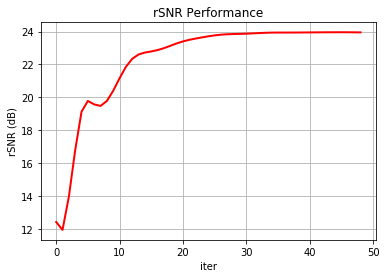

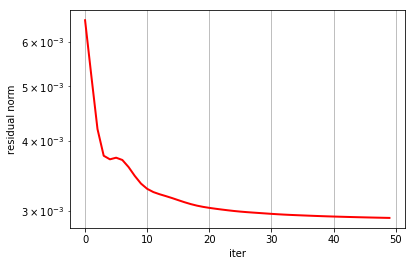

-------------------------------------------------------------------------------------------------------------------
 
NMSE of PnP reconstruction with Least-Squares Ground Truth: -24.34915    
NMSE of PnP reconstruction with RSS Ground Truth: -20.06999    
NMSE of U-Net reconstruction with RSS Ground Truth: -21.86759    
 
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
 
 
NMSE of inner region of PnP reconstruction with Least-Squares Ground Truth: -24.51031    
NMSE of inner region of PnP reconstruction with RSS Ground Truth: -23.94180    
NMSE of inner region of U-Net reconstruction with RSS Ground Truth: -22.06086    
 
-------------------------------------------------------------------------------------------------------------------


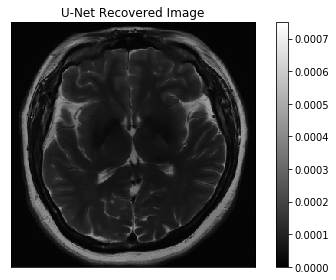

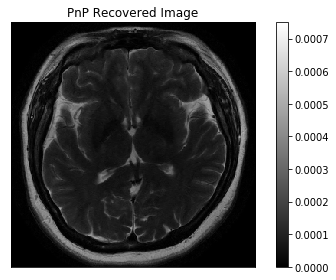

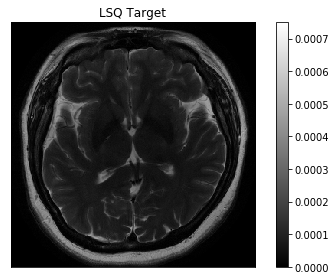

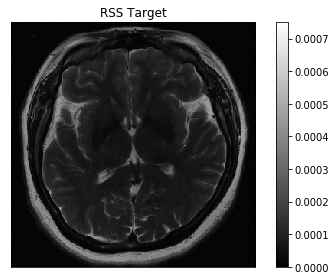

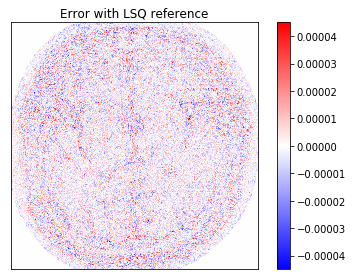

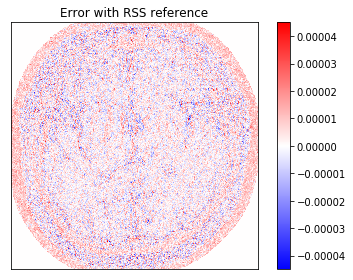

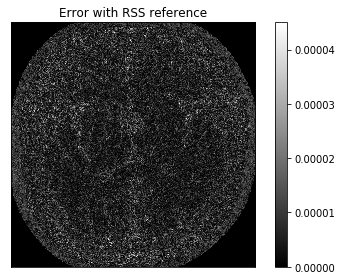

In [22]:

args.snr = 30
args.add_noise = False
args.image_size = 384

with torch.no_grad():
    input_UNet, target_UNet, mean, std, masked_kspace, mask, kspace, RSS_x, coil_compressed_x ,fname, slice, sens_map_foo, lsq_gt = data[0][0:13]  
    input_UNet = input_UNet.unsqueeze(0).unsqueeze(0).to(args.device)
    recon = model_UNet(input_UNet).to('cpu').squeeze()
    recon = recon * std + mean
    recon_UNet = recon.cpu().numpy()
    target_UNet = target_UNet * std + mean
    target_UNet = target_UNet.cpu().numpy()
    

gamma_inp = 18



p = []
pnp_nmse = []
pnp_ssim = []

k = 300
k_ = 20

device=sp.Device(0)

sens_maps = np.zeros((8,384,384)).astype(np.complex)
sens_maps = sp.to_device(sens_maps, -1)

for  i in range(8):
    sens_maps[i,:,:] = sens_map_foo[:,:,i]

sens_maps = transforms.to_tensor(sens_maps.astype('complex64'))

# handle pytorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     device = torch.device("cpu")
sens_maps = sens_maps.to(device)


kspace_np = tensor_to_complex_np(masked_kspace)
# kspace_np = tensor_to_complex_np(kspace)
# print('change this abv line in code')
#     mask = mask.cpu().numpy()



################################################################# Ground Truth

# lsq_gt = np.sum(sens_map_foo.conj()*coil_compressed_x , axis = -1)
#     lsq = RSS_x
#         lsq = np.abs(lsq_gt)
lsq_gt_2 = transforms.to_tensor(np.abs(lsq_gt)).float()
lsq_gt_2 = lsq_gt_2.to(device)


#################################################################



# print(data_index)


mask_tensor = np.zeros((1,384,1,1))
mask_tensor[0,:,0,0]  = mask[0,:,0]
mask_tensor = transforms.to_tensor(mask_tensor)
mask_tensor = mask_tensor.permute(2,0,1,3).float()
    # print(mask_tensor.shape)

mask_tensor = mask_tensor.to(device)

# output_kspace_tensor_modified = output_kspace_tensor_modified.to(device)
masked_kspace_foo = masked_kspace.to(device)

#     lsq = transforms.to_tensor(lsq).float()
#     target = lsq.to(device)

target = transforms.to_tensor(RSS_x).float()
target = target.to(device)

#     lsq_gt_2 = transforms.to_tensor(np.abs(lsq_gt)).float()
#     lsq_gt_2 = lsq_gt_2.to(device)



mri = A_mri(sens_maps, mask_tensor)


mask_tensor_compliment = torch.ones(mask_tensor.shape).to(device) - mask_tensor

mri_B = B_mri(sens_maps, mask_tensor_compliment)
mri_D = D_mri(sens_maps)

max_iter = 50  # Requires early stopping. That's why max_iter limited to 50.

zeta = 0.01
# gamma_inp = 2000
# zeta = 0.0010
gamma_inp =  400

# x_after_pnp_2,  a_nmse_2, a_rSNR_2, gamma_1_log, gamma_2_log, required_res_norm_log_2, res_norm_log_2,input_RMSE, output_RMSE  = pds_generic_3(masked_kspace_foo,model, args, mri, target,max_iter,gamma_inp, mri_B, mri_D, mask_tensor, mask_tensor_compliment,zeta,sens_map_foo)

# x_after_pnp_2,  a_nmse_2, a_rSNR_2, gamma_1_log, gamma_2_log, required_res_norm_log_2, res_norm_log_2,input_RMSE, output_RMSE  = pds_generic_without_kspace(masked_kspace_foo,model, args, mri, target,max_iter,gamma_inp, mri_B, mri_D, mask_tensor, mask_tensor_compliment,zeta,sens_map_foo)

# gamma_inp = 20                                         
x_after_pnp_2,  a_nmse_2, a_rSNR_2, gamma_1_log, gamma_2_log, required_res_norm_log_2, res_norm_log_2,input_RMSE, output_RMSE  = pds_normal(masked_kspace_foo,model, args, mri, target,max_iter,gamma_inp, mri_B, mri_D, mask_tensor, mask_tensor_compliment,zeta,sens_map_foo)


plt.plot(range(max_iter-1), -10*np.log10(a_nmse_2[0:max_iter-1]), 'r-',linewidth=2.0)
# plt.plot(range(max_iter-1), -10*np.log10(a_nmse_AT[0:max_iter-1]), 'b-',linewidth=2.0,label="AT")
# plt.xscale("log")
plt.axis('tight')
plt.xlabel('iter')
plt.ylabel('rSNR (dB)')
# plt.legend(fontsize = 14)
plt.title('rSNR Performance')
plt.grid()
# plt.ylim((18,32))
# plt.savefig("Results/actual_multicoil_knee_PnP_PDS_results/rsnr_performance_dataidx_0_gam1_2000_zeta_0p001_iter100_no_noise.pdf",format ="pdf")
plt.show()



plt.plot(range(max_iter), res_norm_log_2, 'r-',linewidth=2.0)
# plt.plot(range(max_iter+1), res_norm_log_AT, 'b-',linewidth=2.0,label="AT")
# plt.plot(range(max_iter+1), required_res_norm_log_AT, 'g-',linewidth=2.0,label="REQUIRED")
# plt.xscale("log")
plt.yscale("log")
plt.axis('tight')
plt.xlabel('iter')
plt.ylabel('residual norm')
# plt.legend(fontsize = 14)
# plt.savefig("Results/actual_multicoil_knee_PnP_PDS_results/recovered_residual_norm_performance_dataidx_0_gam1_2000_zeta_0p001_iter100_no_noise.pdf",format ="pdf")
plt.grid()
plt.show()

w_from = (args.image_size - 320) // 2  # crop images into 384x384
h_from = (args.image_size - 320) // 2
w_to = w_from + 320
h_to = h_from + 320

# recovered_image_AT = (transforms.complex_abs(x_after_pnp_AT).cpu().numpy())
target_image_rss = (target.cpu().numpy())
target_image_lsq = (lsq_gt_2.cpu().numpy())
# error_image_lsq_AT = target_image_lsq - recovered_image_AT
# error_image_rss_AT = target_image_rss - recovered_image_AT


recovered_image_2 = (transforms.complex_abs(x_after_pnp_2).cpu().numpy())
error_image_lsq_2 = target_image_lsq - recovered_image_2
error_image_rss_2 = target_image_rss - recovered_image_2

error_image_UNet_2 = target_image_rss - recon_UNet



print("-------------------------------------------------------------------------------------------------------------------")

# print('NMSE of PnP reconstruction with Least-Squares Ground Truth AT: {0:.5f}    '.format(10*np.log10(nmse(target_image_lsq, recovered_image_AT))))
# print('NMSE of PnP reconstruction with RSS Ground Truth AT: {0:.5f}    '.format(10*np.log10(nmse(target_image_rss, recovered_image_AT))))
# print(" ")
print(" ")
print('NMSE of PnP reconstruction with Least-Squares Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(np.abs(target_image_lsq), recovered_image_2))))
print('NMSE of PnP reconstruction with RSS Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(target_image_rss, recovered_image_2))))
print('NMSE of U-Net reconstruction with RSS Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(target_UNet, recon_UNet))))
print(" ")


sens_map_zero_count = 0
AA = torch.zeros(384,384)
AA_ones = torch.zeros(384,384) + 1
for i in range(384):
    for j in range(384):
        if np.sum(np.abs(sens_map_foo[i,j,:])) == 0:
            sens_map_zero_count = sens_map_zero_count+1
            AA[i,j] = 1
            AA_ones[i,j] = 0



tar_1 = np.abs(target_image_lsq)*AA_ones.numpy()
rec_1 = recovered_image_2*AA_ones.numpy()
tar_2 = target_image_rss*AA_ones.numpy()
rec_2 = recovered_image_2*AA_ones.numpy()
rec_UNet_2 =recon_UNet*AA_ones.numpy()
tar_UNet_2 =target_UNet*AA_ones.numpy()

# print("percentage of zero (we want it to be less than 0.25): ", format(sens_map_zero_count/(384*384)))   
print("-------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------")

# print(" ")
# print('NMSE of inner region of PnP reconstruction with Least-Squares Ground Truth AT: {0:.5f}    '.format(10*np.log10(nmse(np.abs(target_image_lsq)*AA_ones.numpy(), recovered_image_AT*AA_ones.numpy()))))
# print('NMSE of inner region of PnP reconstruction with RSS Ground Truth AT: {0:.5f}    '.format(10*np.log10(nmse(target_image_rss*AA_ones.numpy(), recovered_image_AT*AA_ones.numpy()))))

print(" ")
print(" ")
print('NMSE of inner region of PnP reconstruction with Least-Squares Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(tar_1[w_from:w_to, h_from:h_to],rec_1[w_from:w_to, h_from:h_to] ))))
print('NMSE of inner region of PnP reconstruction with RSS Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(tar_2[w_from:w_to, h_from:h_to],rec_2[w_from:w_to, h_from:h_to]))))
print('NMSE of inner region of U-Net reconstruction with RSS Ground Truth: {0:.5f}    '.format(10*np.log10(nmse(tar_UNet_2[w_from:w_to, h_from:h_to],rec_UNet_2[w_from:w_to, h_from:h_to]))))
print(" ")
print("-------------------------------------------------------------------------------------------------------------------")


plt.imshow(recon_UNet[w_from:w_to, h_from:h_to], origin='lower', cmap='gray',vmin=0, vmax=0.00075)
plt.title('U-Net Recovered Image')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.imshow(recovered_image_2[w_from:w_to, h_from:h_to], origin='lower', cmap='gray',vmin=0, vmax=0.00075)
plt.title('PnP Recovered Image')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()



plt.imshow(target_image_lsq[w_from:w_to, h_from:h_to], origin='lower', cmap='gray',vmin=0, vmax=0.00075)
# plt.imshow(target_image_rss, origin='lower', cmap='gray',vmin=0, vmax=0.00053)
plt.title('LSQ Target')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.imshow(target_image_rss[w_from:w_to, h_from:h_to], origin='lower', cmap='gray',vmin=0,vmax=0.00075)
plt.title('RSS Target')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()

err_1 = error_image_lsq_2*AA_ones.numpy()

plt.imshow(err_1[w_from:w_to, h_from:h_to], origin='lower', cmap='bwr',vmin=-0.000045, vmax=0.000045)
# plt.imshow(err_1[w_from:w_to, h_from:h_to], origin='lower', cmap='bwr')

plt.title('Error with LSQ reference')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()

err_2 = error_image_rss_2*AA_ones.numpy()
plt.imshow(err_2[w_from:w_to, h_from:h_to], origin='lower', cmap='bwr',vmin=-0.000045, vmax=0.000045)
# plt.imshow(err_2[w_from:w_to, h_from:h_to], origin='lower', cmap='bwr')
plt.title('Error with RSS reference')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()

# err_2 = error_image_rss_2*AA_ones.numpy()
plt.imshow(np.abs(err_2[w_from:w_to, h_from:h_to]), origin='lower',cmap='gray',vmin=0, vmax=0.000045)
plt.title('Error with RSS reference')
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.tight_layout()
plt.show()


# compare_ssim(np.abs(tar_2),np.abs(rec_2), data_range=tar_2.max())